In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    make_scorer,
    roc_curve,
    auc,
    recall_score,
)

import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder

/home/elicer/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-15 13:56:49.359023: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-15 13:56:49.401422: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 13:56:51.043020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find Tenso

In [2]:
f1_scorer = make_scorer(f1_score, pos_label=1, average = 'binary')

In [3]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [4]:
# 데이터 불러오기
train = pd.read_csv('./data/train_0815_variable.csv')
test = pd.read_csv('./data/test_0815_variable.csv')

In [5]:
# pallet 변수 형태 지정하기
train['pallet'] = train['pallet'].astype('int64')
test['pallet'] = test['pallet'].astype('int64')

In [6]:
# target값을 숫자로 바꾸기
train['target_num'] = np.where(train['target'] == 0, 1, -1)

In [7]:
train['target'].value_counts()

target
0    38156
1     2350
Name: count, dtype: int64

In [8]:
# index 
train_index = train[train['target'] == 0].sample(38156-2350, random_state = 42).index

In [9]:
# one class train, valid split
df_train = train[train.index.isin(train_index)]
df_valid = train[~train.index.isin(train_index)]

In [10]:
# 각 영역별 
stage1 = ['target_num', 'stage1_dist_cat',
       'cure_time_dam', 'cure_time_fill2', 'thon_time',
       'fill2_time',
       'discharged_dist_stage1_dam',
       'pallet', 'select_workorder',
       'model_suffix']

stage2 = [
        'target_num', 
       'stage2_dist_cat', 
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 
       'fill2_time',
       'discharged_dist_stage2_dam',
       'pallet', 'select_workorder',
       'model_suffix'
        ]

stage3 = [
        'target_num', 'stage3_dist_cat',
       'cure_time_dam', 'cure_time_fill2', 'thon_time', 
       'fill2_time',
       'discharged_dist_stage3_dam',
       'pallet', 'select_workorder',
       'model_suffix'
]

autoclave = [
        'target_num',
       'press21_autoclave',
        'autoclave_time', 'pallet',
       'chamber_temp', 'model_suffix', 'select_workorder'
            ]

df_train_stage1 = df_train[stage1]
df_train_stage2 = df_train[stage2]
df_train_stage3 = df_train[stage3]
df_train_autoclave = df_train[autoclave]

df_valid_stage1 = df_valid[stage1]
df_valid_stage2 = df_valid[stage2]
df_valid_stage3 = df_valid[stage3]
df_valid_autoclave = df_valid[autoclave]

## Stage1

In [11]:
# train, valid 
Xt_stage1 = df_train_stage1[df_train_stage1.columns.difference(['target_num'])]

Xv_stage1 = df_valid_stage1[df_valid_stage1.columns.difference(['target_num'])]
yv_stage1 = df_valid_stage1['target_num']

In [12]:
# IsolationForest 모델 만들기
isol_stage1 = IsolationForest(max_samples=100, random_state = 42) 

# 만들어 둔 데이터셋에 알고리즘 피팅시키기
isol_stage1.fit(Xt_stage1)

# 예측해보기
y_pred_vaild_stage1 = isol_stage1.predict(Xv_stage1)

In [13]:
np.unique(yv_stage1, return_counts = True)

(array([-1,  1]), array([2350, 2350]))

In [14]:
np.unique(y_pred_vaild_stage1, return_counts = True)

(array([-1,  1]), array([1898, 2802]))

In [15]:
get_clf_eval(yv_stage1, y_pred_vaild_stage1)

오차행렬:
 [[1123 1227]
 [ 775 1575]]

정확도: 0.5740
정밀도: 0.5621
재현율: 0.6702
F1: 0.6114


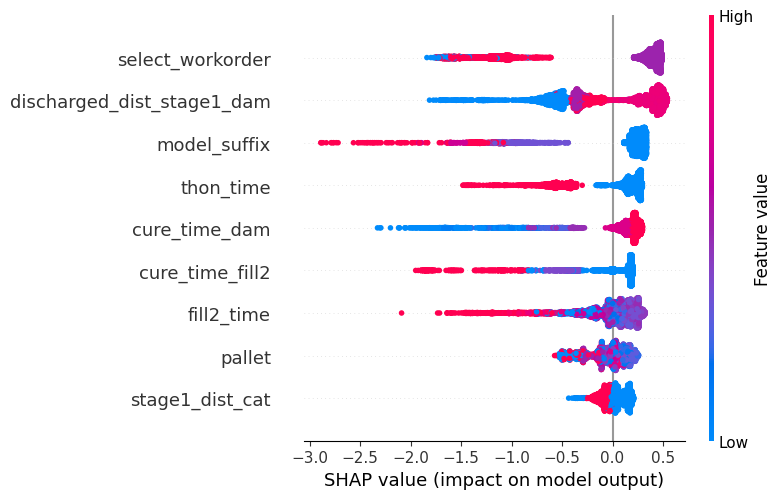

In [16]:
import shap
explainer = shap.Explainer(isol_stage1)
shap_values = explainer(Xv_stage1)
shap.initjs()

shap.summary_plot(shap_values, Xv_stage1)

## Stage2

In [17]:
# train, valid 
Xt_stage2 = df_train_stage2[df_train_stage2.columns.difference(['target_num'])]

Xv_stage2 = df_valid_stage2[df_valid_stage2.columns.difference(['target_num'])]
yv_stage2 = df_valid_stage2['target_num']

In [18]:
# IsolationForest 모델 만들기
isol_stage2 = IsolationForest(max_samples=100, random_state = 42) 

# 만들어 둔 데이터셋에 알고리즘 피팅시키기
isol_stage2.fit(Xt_stage2)

# 예측해보기
y_pred_vaild_stage2 = isol_stage2.predict(Xv_stage2)

In [19]:
get_clf_eval(yv_stage2, y_pred_vaild_stage2)

오차행렬:
 [[1142 1208]
 [ 842 1508]]

정확도: 0.5638
정밀도: 0.5552
재현율: 0.6417
F1: 0.5953


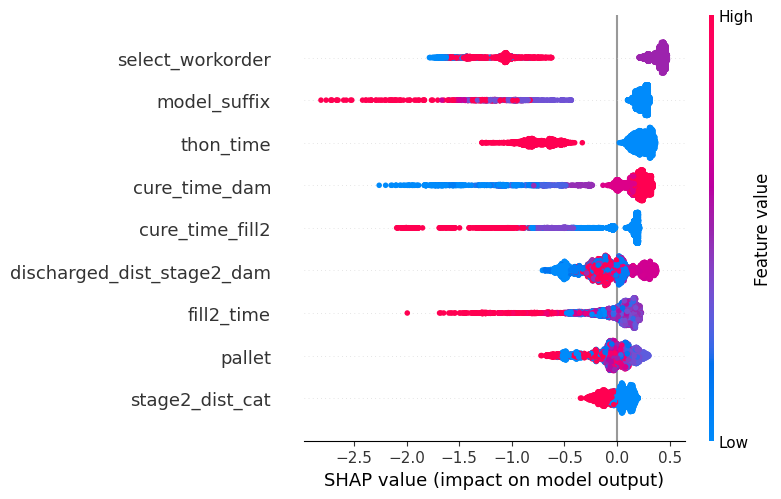

In [20]:
explainer = shap.Explainer(isol_stage2)
shap_values = explainer(Xv_stage2)
shap.initjs()

shap.summary_plot(shap_values, Xv_stage2)

## Stage3

In [21]:
# train, valid 
Xt_stage3 = df_train_stage3[df_train_stage3.columns.difference(['target_num'])]

Xv_stage3 = df_valid_stage3[df_valid_stage3.columns.difference(['target_num'])]
yv_stage3 = df_valid_stage3['target_num']

In [22]:
# IsolationForest 모델 만들기
isol_stage3 = IsolationForest(max_samples=100, random_state = 42) 

# 만들어 둔 데이터셋에 알고리즘 피팅시키기
isol_stage3.fit(Xt_stage3)

# 예측해보기
y_pred_vaild_stage3 = isol_stage3.predict(Xv_stage3)

In [23]:
get_clf_eval(yv_stage3, y_pred_vaild_stage3)

오차행렬:
 [[1044 1306]
 [ 772 1578]]

정확도: 0.5579
정밀도: 0.5472
재현율: 0.6715
F1: 0.6030


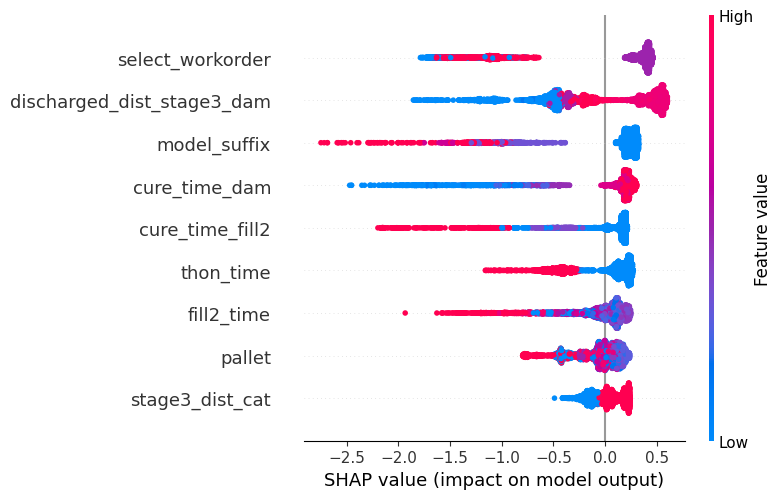

In [24]:
explainer = shap.Explainer(isol_stage3)
shap_values = explainer(Xv_stage3)
shap.initjs()

shap.summary_plot(shap_values, Xv_stage3)

## Autoclave

In [25]:
# train, valid 
Xt_autoclave = df_train_autoclave[df_train_autoclave.columns.difference(['target_num'])]

Xv_autoclave = df_valid_autoclave[df_valid_autoclave.columns.difference(['target_num'])]
yv_autoclave = df_valid_autoclave['target_num']

In [26]:
# IsolationForest 모델 만들기
isol_autoclave = IsolationForest(max_samples=100, random_state = 42) 

# 만들어 둔 데이터셋에 알고리즘 피팅시키기
isol_autoclave.fit(Xt_autoclave)

# 예측해보기
y_pred_vaild_autoclave = isol_autoclave.predict(Xv_autoclave)

In [27]:
np.unique(yv_autoclave, return_counts = True)

(array([-1,  1]), array([2350, 2350]))

In [28]:
np.unique(y_pred_vaild_autoclave, return_counts = True)

(array([-1,  1]), array([2223, 2477]))

In [29]:
get_clf_eval(yv_autoclave, y_pred_vaild_autoclave)

오차행렬:
 [[1240 1110]
 [ 983 1367]]

정확도: 0.5547
정밀도: 0.5519
재현율: 0.5817
F1: 0.5664


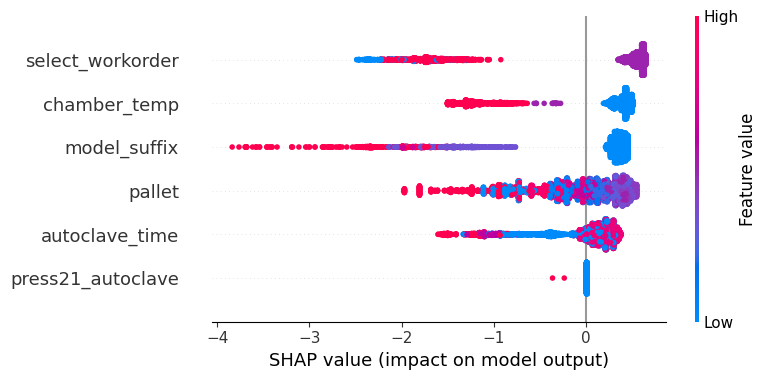

In [30]:
explainer = shap.Explainer(isol_autoclave)
shap_values = explainer(Xv_autoclave)
shap.initjs()

shap.summary_plot(shap_values, Xv_autoclave)

# 민감성

In [32]:
test_stage1_x = test[Xt_stage1.columns]
test_stage2_x = test[Xt_stage2.columns]
test_stage3_x = test[Xt_stage3.columns]
test_AutoClave_x = test[Xt_autoclave.columns]

In [33]:
dam_test_pred = isol_stage1.predict(test_stage1_x)
dam_test_pred

array([ 1,  1,  1, ...,  1, -1,  1])

In [34]:
fill1_test_pred = isol_stage2.predict(test_stage2_x)
fill1_test_pred

array([ 1,  1, -1, ...,  1, -1, -1])

In [35]:
fill2_test_pred = isol_stage3.predict(test_stage3_x)
fill2_test_pred

array([ 1,  1, -1, ...,  1, -1, -1])

In [36]:
AutoClave_test_pred = isol_autoclave.predict(test_AutoClave_x)
AutoClave_test_pred

array([ 1,  1,  1, ...,  1, -1, -1])

In [37]:
result = np.where(
    (dam_test_pred == 1) & (fill1_test_pred == 1) & (fill2_test_pred == 1) & (AutoClave_test_pred) == 1, 'Normal', 'AbNormal'
)

In [38]:
np.unique(result, return_counts = True)

(array(['AbNormal', 'Normal'], dtype='<U8'), array([ 6865, 10496]))

In [39]:
test['target'] = result

In [40]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,6850,10483
1,15,13


In [41]:
test['target'] = np.where(test['inconsistant'] == 1, 'AbNormal', test['target'])

In [42]:
pd.crosstab(test['inconsistant'], test['target'])

target,AbNormal,Normal
inconsistant,,
0,6850,10483
1,28,0


In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = result

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)